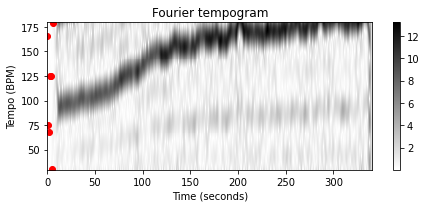

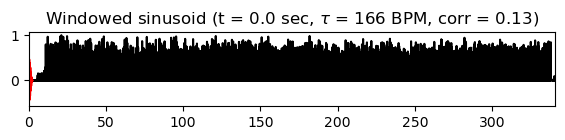

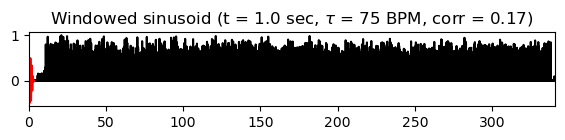

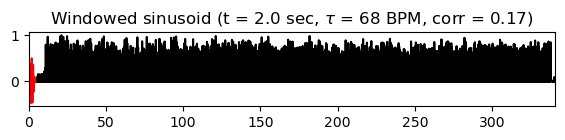

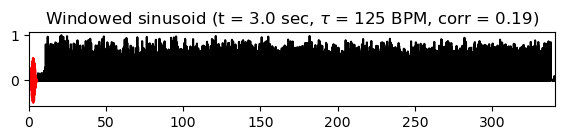

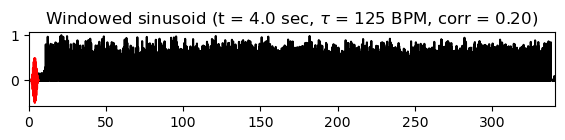

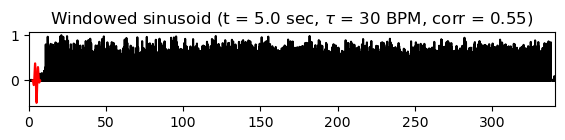

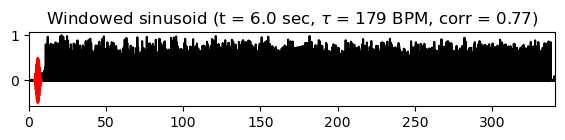

In [7]:
import os
import sys
import numpy as np
from numba import jit
import librosa
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

%matplotlib inline

# fn_wav = 'Shostakovich.mp3'
fn_wav = '/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/bamako_audio/BKO_E1_D1_02_Maraka_M-Jem-2.wav'
Fs = 22050
x, Fs = librosa.load(path=fn_wav, sr=Fs) 

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, 
                                                 gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500 #corresponding to 5 seconds (Fs_nov = 100 Hz)
H = 10  #Hopsize leading to a tempogram resolution of 10 Hz
Theta = np.arange(30, 180) #Tempo range parameter
X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs=Fs_nov, N=N, H=H, 
                                                            Theta=Theta)
tempogram = np.abs(X)

t_nov = np.arange(nov.shape[0]) / Fs_nov
coef_n = np.array([0, 10, 20, 30, 40, 50, 60])
coef_k = np.zeros(len(coef_n), dtype=int)

for i in range(len(coef_n)):
    coef_k[i] = np.argmax(tempogram[:,coef_n[i]])

fig, ax, im = libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, 
                                   figsize=(6.5, 3), ylabel='Tempo (BPM)',
                                   title='Fourier tempogram')
ax[0].plot(T_coef[coef_n], F_coef_BPM[coef_k], 'ro')

for i in range(len(coef_n)):
    n = coef_n[i]
    k = coef_k[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    corr = np.abs(X[k,n])
    kernel, t_kernel, t_kernel_sec = libfmp.c6.compute_sinusoid_optimal(X[k,n], 
                                            F_coef_BPM[k], n, Fs_nov, N, H)
    title=r'Windowed sinusoid (t = %0.1f sec, $\tau$ = %0.0f BPM, corr = %0.2f)'% (time, tempo, corr)
    libfmp.c6.plot_signal_kernel(nov, t_nov, 0.5*kernel, t_kernel_sec, 
                                 figsize=(6, 1.5), title=title) 

In [ ]:
L = nov.shape[0]
N_left = N // 2
L_left = N_left
L_right = N_left
L_pad = L + L_left + L_right
t_pad = np.arange(L_pad)

t_nov = np.arange(nov.shape[0]) / Fs_nov
coef_n = np.array([0, 10, 20, 30, 40, 50, 60])
coef_k = np.zeros(len(coef_n), dtype=int)

for i in range(len(coef_n)):
    coef_k[i] = np.argmax(tempogram[:, coef_n[i]])

fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2, 2, 1, 1]}, figsize=(8, 9))        

libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0, 0], color='k', title='Novelty function')
ax[0, 1].set_axis_off()

libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], 
                     title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True)
ax[1, 0].plot(T_coef[coef_n], F_coef_BPM[coef_k], 'ro')

libfmp.b.plot_signal(nov, Fs_nov, ax=ax[2, 0], color='k', title='Novelty function with windowed sinusoids')
ax[2, 1].set_axis_off()

nov_PLP = np.zeros(L_pad)
for i in range(len(coef_n)):
    n = coef_n[i]
    k = coef_k[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    kernel, t_kernel, t_kernel_sec = libfmp.c6.compute_sinusoid_optimal(X[k, n], F_coef_BPM[k], n, Fs_nov, N, H)    
    nov_PLP[t_kernel] = nov_PLP[t_kernel] + kernel
    ax[2, 0].plot(t_kernel_sec, 0.5 * kernel, 'r')
    ax[2, 0].set_ylim([-0.6, 1])
    
nov_PLP = nov_PLP[L_left:L_pad-L_right]
libfmp.b.plot_signal(nov_PLP, Fs_nov, ax=ax[3, 0], color='r', title='Accumulated windowed sinusoids')
ax[3,1].set_axis_off()

nov_PLP[nov_PLP < 0] = 0
libfmp.b.plot_signal(nov_PLP, Fs_nov, ax=ax[4, 0], color='r', title='PLP function $\Gamma$')
ax[4, 1].set_axis_off()

plt.tight_layout()

In [ ]:
def compute_plp(X, Fs, L, N, H, Theta):
    """Compute windowed sinusoid with optimal phase

    Notebook: C6/C6S3_PredominantLocalPulse.ipynb

    Args:
        X (np.ndarray): Fourier-based (complex-valued) tempogram
        Fs (scalar): Sampling rate
        L (int): Length of novelty curve
        N (int): Window length
        H (int): Hop size
        Theta (np.ndarray): Set of tempi (given in BPM)

    Returns:
        nov_PLP (np.ndarray): PLP function
    """
    win = np.hanning(N)
    N_left = N // 2
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    nov_PLP = np.zeros(L_pad)
    M = X.shape[1]
    tempogram = np.abs(X)
    for n in range(M):
        k = np.argmax(tempogram[:, n])
        tempo = Theta[k]
        omega = (tempo / 60) / Fs
        c = X[k, n]
        phase = - np.angle(c) / (2 * np.pi)
        t_0 = n * H
        t_1 = t_0 + N
        t_kernel = np.arange(t_0, t_1)
        kernel = win * np.cos(2 * np.pi * (t_kernel * omega - phase))
        nov_PLP[t_kernel] = nov_PLP[t_kernel] + kernel
    nov_PLP = nov_PLP[L_left:L_pad-L_right]
    nov_PLP[nov_PLP < 0] = 0
    return nov_PLP

# fn_wav = 'Shostakovich.mp3'
fn_wav = '/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/bamako_audio/BKO_E1_D1_02_Maraka_M-Jem-2.wav'
Fs = 22050
x, Fs = librosa.load(path=fn_wav, sr=Fs) 

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, 
                                                 gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

L = len(nov)
N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs=Fs_nov, N=N, H=H, 
                                                            Theta=Theta)
nov_PLP = compute_plp(X, Fs_nov, L, N, H, Theta)

t_nov = np.arange(nov.shape[0]) / Fs_nov
peaks, properties = signal.find_peaks(nov, prominence=0.02)
peaks_sec = t_nov[peaks]
libfmp.b.plot_signal(nov, Fs_nov, color='k', title='Novelty function with detected peaks');
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()
x_peaks = librosa.clicks(times=peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

peaks, properties = signal.find_peaks(nov_PLP, prominence=0.02)
peaks_sec = t_nov[peaks]
libfmp.b.plot_signal(nov_PLP, Fs_nov, color='k', title='PLP function with detected peaks');
plt.plot(peaks_sec, nov_PLP[peaks], 'ro')
plt.show()
x_peaks = librosa.clicks(times=peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

In [ ]:
plt.figure(figsize=(40, 6), dpi=300)
plt.plot(nov_PLP)
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo Curve Over Time')
plt.grid(True)
plt.show()

In [ ]:
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4
import libfmp.c6

# Tempogram
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs_nov, N=1000, H=100, Theta=np.arange(30, 601))

octave_bin = 30
tempogram_F = np.abs(X)
output = libfmp.c6.compute_cyclic_tempogram(tempogram_F, F_coef_BPM, octave_bin=octave_bin)
tempogram_cyclic_F = output[0]
F_coef_scale = output[1]
tempogram_cyclic_F = libfmp.c3.normalize_feature_sequence(tempogram_cyclic_F, norm='max')

output = libfmp.c6.compute_tempogram_autocorr(nov, Fs_nov, N=500, H=100, norm_sum=False,
                                              Theta=np.arange(30, 601))
tempogram_A = output[0]
T_coef = output[1]
F_coef_BPM = output[2]

output = libfmp.c6.compute_cyclic_tempogram(tempogram_A, F_coef_BPM, octave_bin=octave_bin)
tempogram_cyclic_A = output[0]
F_coef_scale = output[1]
tempogram_cyclic_A = libfmp.c3.normalize_feature_sequence(tempogram_cyclic_A, norm='max')

# Visualization
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [2, 2, 0.5]}, figsize=(9, 5))       

libfmp.b.plot_matrix(tempogram_cyclic_F, T_coef=T_coef, ax=[ax[0,0], ax[0,1]], 
                     title='Fourier-based cyclic tempogram', ylabel='Scaling',
                     colorbar=True, clim=[0, 1])
libfmp.c6.set_yticks_tempogram_cyclic(ax[0,0], octave_bin, F_coef_scale, num_tick=5)

libfmp.b.plot_matrix(tempogram_cyclic_A, T_coef=T_coef, ax=[ax[1,0], ax[1,1]], 
                     title='Autocorrelation-based cyclic tempogram', ylabel='Scaling',
                     colorbar=True, clim=[0, 1])
libfmp.c6.set_yticks_tempogram_cyclic(ax[1,0], octave_bin, F_coef_scale, num_tick=5)

# libfmp.b.plot_segments(ann, ax=ax[2,0], time_max=x_dur, 
#                        colors=color_ann, time_label='Time (seconds)')
ax[2,1].axis('off')

plt.tight_layout()